In [4]:
import os
import cv2
import random
import pickle
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import shutil
import itertools
import imutils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D , BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

In [5]:
def preprocess(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    
    return new_image

In [7]:
datadir = ['brain_tumor_dataset/','augmented_brain_tumor_dataset/']
CATEGORIES = ['no','yes']
training_data_feature = []
training_data_label = []
IMG_SIZE = 120

def create_training_data():
    for DATADIR in datadir:
        for category in CATEGORIES:
            path = os.path.join(DATADIR, category)
            class_num = CATEGORIES.index(category) # categories for dog(0) and cat(1)
            for img in tqdm(os.listdir(path)):
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    image = preprocess(img_array)
                    new_array = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
                    new_array = new_array/255.0
                    training_data_feature.append(new_array)
                    training_data_label.append(class_num)
                except Exception as e:
                    pass
        
create_training_data()

100%|██████████| 10492/10492 [00:36<00:00, 287.45it/s]


(120, 120, 3)

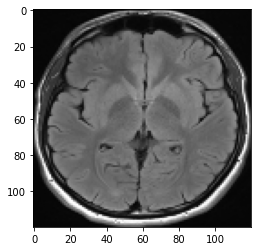

In [8]:
training_data_feature = np.array(training_data_feature)
training_data_label = np.array(training_data_label)
plt.imshow(training_data_feature[20])
training_data_feature[20].shape

In [9]:
X_train, X_test, y_train, y_test = train_test_split(training_data_feature,training_data_label, test_size=0.05)

## CATDOG MODEL

In [10]:
model = Sequential()

model.add(Conv2D(64, (3,3), (1,1), input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) #to convert 3D feature map to 1D
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
677/677 [==============================] - 254s 373ms/step - loss: 0.4894 - accuracy: 0.7670 - val_loss: 0.2434 - val_accuracy: 0.8945
Epoch 2/5
677/677 [==============================] - 261s 385ms/step - loss: 0.1501 - accuracy: 0.9408 - val_loss: 0.1348 - val_accuracy: 0.9490
Epoch 3/5
677/677 [==============================] - 275s 406ms/step - loss: 0.0787 - accuracy: 0.9701 - val_loss: 0.0921 - val_accuracy: 0.9684
Epoch 4/5
677/677 [==============================] - 276s 407ms/step - loss: 0.0422 - accuracy: 0.9856 - val_loss: 0.1076 - val_accuracy: 0.9651
Epoch 5/5
677/677 [==============================] - 278s 411ms/step - loss: 0.0261 - accuracy: 0.9918 - val_loss: 0.1045 - val_accuracy: 0.9730


In [13]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

45/45 [==============================] - 5s 109ms/step - loss: 0.0791 - accuracy: 0.9811
Test loss: 0.07908977568149567
Test accuracy: 0.9810526371002197


In [15]:
test_image = cv2.imread('test/arifk1.jpg')
test_image = preprocess(test_image)
new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
new_array = new_array/255.0

test_image = np.array(new_array)
X_test[0]=test_image
ynew = model.predict_classes(X_test)
ynew[0]

/Users/egemenakbal/opt/miniconda3/envs/tfp-gpu/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1], dtype=int32)

## CIFAR MODEL

In [16]:
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_SIZE,IMG_SIZE,3)))
model5.add(BatchNormalization())
model5.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.3))
model5.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.4))
model5.add(Flatten())
model5.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(1, activation='sigmoid'))

In [17]:
model5.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [18]:
history = model5.fit(X_train,y_train,epochs=5,batch_size=64,validation_split=0.1)

Epoch 1/5
381/381 [==============================] - 936s 2s/step - loss: 0.4474 - accuracy: 0.8089 - val_loss: 0.3867 - val_accuracy: 0.8825
Epoch 2/5
381/381 [==============================] - 1052s 3s/step - loss: 0.1234 - accuracy: 0.9559 - val_loss: 0.2099 - val_accuracy: 0.9194
Epoch 3/5
381/381 [==============================] - 1016s 3s/step - loss: 0.0641 - accuracy: 0.9773 - val_loss: 0.1076 - val_accuracy: 0.9582
Epoch 4/5
381/381 [==============================] - 981s 3s/step - loss: 0.0521 - accuracy: 0.9811 - val_loss: 0.6201 - val_accuracy: 0.8574
Epoch 5/5
381/381 [==============================] - 973s 3s/step - loss: 0.0298 - accuracy: 0.9902 - val_loss: 0.2987 - val_accuracy: 0.9161


In [19]:
scores = model5.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

45/45 [==============================] - 9s 207ms/step - loss: 0.2757 - accuracy: 0.9207
Test loss: 0.2756807804107666
Test accuracy: 0.9207017421722412


array([1], dtype=int32)

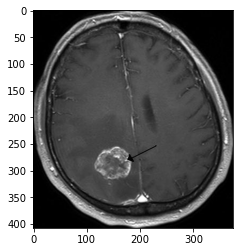

In [21]:
test_image = cv2.imread('test/arifk1.jpg')
test_image = preprocess(test_image)
new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
new_array = new_array/255.0

plt.imshow(test_image)

test_image = np.array(new_array)
X_test[0]=test_image
ynew = model5.predict_classes(X_test)
ynew[0]

## INCEPTIONV3

In [22]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions, preprocess_input

modelINCEPTION = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    #input_shape=(IMG_SIZE,IMG_SIZE,3)
)

96116736/96112376 [==============================] - 33s 0us/step


In [23]:
#print("model structure: ", modelINCEPTION.summary()) 

In [35]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions, preprocess_input

'''last_layer = modelINCEPTION.get_layer('mixed10')

last_output = last_layer.output

z = Flatten()(last_output)

z = Dense(1024, activation = 'relu')(z) 

z = Dropout(0.2)(z)

z= Dense(1, activation = 'sigmoid')(z)

model2 = Model(modelINCEPTION.input, z)'''

model2 = Sequential()
model2.add(InceptionV3(include_top=False,pooling='max', weights="imagenet"))
model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))
model2.layers[0].trainable = False

In [36]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
history = model2.fit(X_train,y_train,epochs=5,batch_size=64,validation_split=0.1)

Epoch 1/5
381/381 [==============================] - 126s 319ms/step - loss: 0.6445 - accuracy: 0.8760 - val_loss: 0.0866 - val_accuracy: 0.9730
Epoch 2/5
381/381 [==============================] - 115s 301ms/step - loss: 0.0928 - accuracy: 0.9664 - val_loss: 0.0889 - val_accuracy: 0.9656
Epoch 3/5
381/381 [==============================] - 114s 301ms/step - loss: 0.0637 - accuracy: 0.9766 - val_loss: 0.0631 - val_accuracy: 0.9767
Epoch 4/5
381/381 [==============================] - 115s 302ms/step - loss: 0.0447 - accuracy: 0.9843 - val_loss: 0.0428 - val_accuracy: 0.9852
Epoch 5/5
381/381 [==============================] - 113s 297ms/step - loss: 0.0342 - accuracy: 0.9888 - val_loss: 0.0354 - val_accuracy: 0.9885


In [49]:
scores = model2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

45/45 [==============================] - 6s 121ms/step - loss: 0.0277 - accuracy: 0.9888
Test loss: 0.027671674266457558
Test accuracy: 0.988771915435791


array([1], dtype=int32)

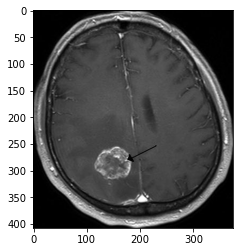

In [52]:
test_image = cv2.imread('test/arifk1.jpg')
test_image = preprocess(test_image)
new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
new_array = new_array/255.0

plt.imshow(test_image)

test_image = np.array(new_array)
X_test[0]=test_image
ynew = model2.predict_classes(X_test)
ynew[0]